# Guitar Classification (powered by PyTorch)

This projects serves as a comparison between the TensorFlow and the PyTorch implementation of a Guitar Classification deep learning model.

In fact, the deep learning model obtained with PyTorch appears to perform better than TensorFlow's (96% accuracy vs 61% accuracy).

This might have happened due to the transformations / pre-processing applied to the images, since the neural networks have a similar structure.

### Based on the following [tutorial](https://www.tensorflow.org/tutorials/images/classification).

## 1. Load Dataset

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
# Load Dataset
import pathlib
data_dir = pathlib.Path('data')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8500


Here's a Les Paul


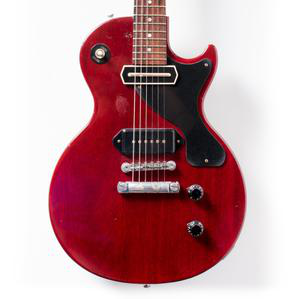

In [3]:
print("Here's a Les Paul")
les_pauls = list(data_dir.glob('gibson_les_paul/*'))
PIL.Image.open(str(les_pauls[0]))

Here's a Strat


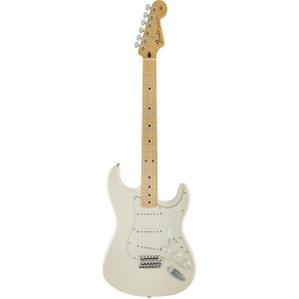

In [4]:
print ("Here's a Strat")
strats = list(data_dir.glob('fender_stratocaster/*'))
PIL.Image.open(str(strats[0]))

## 2. Prepare Datasets

In [5]:
# Split Dataset (Training (70%) / Test (30%))
batch_size = 32
img_height = 180
img_width = 180

transform = transforms.Compose([
    transforms.Resize([img_width, img_height]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.3)

train_set, test_set = random_split(dataset, [train_size, test_size])

train_ds = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_ds = DataLoader(test_set, batch_size=batch_size, shuffle=False)

['fender_jaguar', 'fender_jazzmaster', 'fender_mustang', 'fender_stratocaster', 'fender_telecaster', 'gibson_ES', 'gibson_Flying_V', 'gibson_SG', 'gibson_explorer', 'gibson_firebird', 'gibson_les_paul']


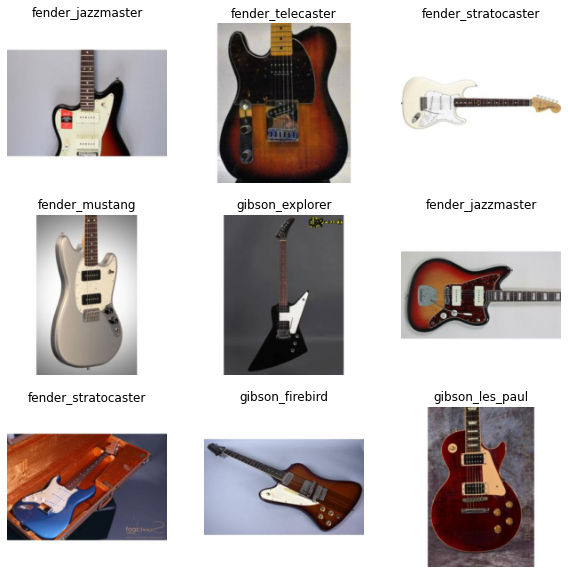

In [6]:
# Visualize the data
import matplotlib.pyplot as plt

class_names = dataset.classes
print(class_names)

invert_norm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
    std=[1/0.229, 1/0.224, 1/0.225]
)

sample_img, sample_lab = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    orig_img = invert_norm(sample_img[idx])
    plt.imshow(orig_img.permute(1, 2, 0).numpy())
    plt.title(class_names[sample_lab[idx].item()])
    plt.axis("off")

## 4. Model Creation

In [7]:
# Hyperparameters
num_classes = len(dataset.classes)

# The model consists of three convolution blocks with a max pool layer in each of them. 
# There's a fully connected layer with 128 units on top of it that is activated by a relu activation function
model = nn.Sequential(
  nn.Conv2d(3, 16, 5),
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  nn.Conv2d(16, 32, 5),
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  nn.Conv2d(32, 64, 5),
  nn.ReLU(),
  nn.MaxPool2d(2, 2),
  nn.Dropout(0.2),
  nn.Flatten(1),
  nn.Linear(64 * 19 * 19, 128),
  nn.ReLU(),
  nn.Linear(128, num_classes)
)

In [8]:
# Criterion and Optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Model Summary
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.2, inplace=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=23104, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=11, bias=True)
)

## 5. Model Training and Evaluation 

In [10]:
# Training and Evaluation methods

# Executes one epoch of training
def train(train_ds):
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_ds):
        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backwards Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accuracy Calculation
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return correct, total, loss

# Executes one epoch of evaluation
def evaluate(test_ds):
    val_correct = 0
    val_total = 0
    
    for i, (images, labels) in enumerate(test_ds):
        # Predict on test data
        outputs = model(images)
        
        # Loss Calculation
        val_loss = criterion(outputs, labels) 
        optimizer.zero_grad()
        
        # Accuracy Calculation
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()
    
    return val_correct, val_total, val_loss

In [12]:
epochs=10

history = {
    "accuracy": [],
    "val_accuracy": [],
    "loss": [],
    "val_loss": []
}

print("Started Training...")

for epoch in range(epochs):
    correct, total, loss = train(train_ds)
    val_correct, val_total, val_loss = evaluate(train_ds)

    acc = correct / total
    val_acc = val_correct / val_total
    
    history["accuracy"].append(acc)
    history["val_accuracy"].append(val_acc)
    history["loss"].append(loss)
    history["val_loss"].append(val_loss)
    
    print(f'epoch {epoch + 1}/{epochs}, loss = {loss:.4f}, val_loss = {val_loss:.4f}, accuracy = {acc:.4f}, val_accuracy = {val_acc:.4f}')

print("Finished Training!")

Started Training...
epoch 1/10, loss = 1.8215, val_loss = 2.0796, accuracy = 0.2133, val_accuracy = 0.3504
epoch 2/10, loss = 1.6404, val_loss = 1.7057, accuracy = 0.4240, val_accuracy = 0.5387
epoch 3/10, loss = 1.5221, val_loss = 0.7752, accuracy = 0.5729, val_accuracy = 0.6908
epoch 4/10, loss = 0.9229, val_loss = 0.7329, accuracy = 0.6881, val_accuracy = 0.7778
epoch 5/10, loss = 0.7819, val_loss = 0.4757, accuracy = 0.7681, val_accuracy = 0.8376
epoch 6/10, loss = 0.7319, val_loss = 0.3790, accuracy = 0.8329, val_accuracy = 0.8869
epoch 7/10, loss = 0.3152, val_loss = 0.4342, accuracy = 0.8728, val_accuracy = 0.9161
epoch 8/10, loss = 0.3790, val_loss = 0.1990, accuracy = 0.9061, val_accuracy = 0.9356
epoch 9/10, loss = 0.2543, val_loss = 0.1833, accuracy = 0.9267, val_accuracy = 0.9588
epoch 10/10, loss = 0.0487, val_loss = 0.3196, accuracy = 0.9405, val_accuracy = 0.9610
Finished Training!


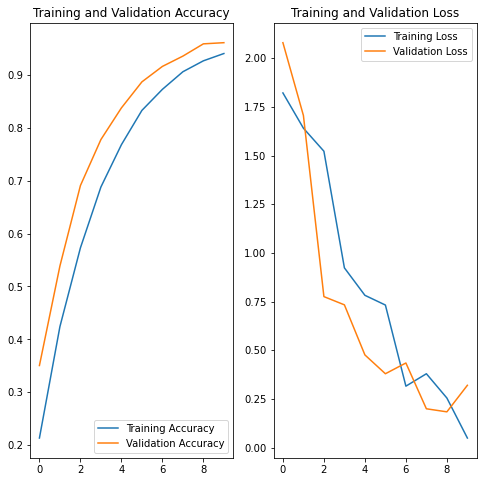

In [13]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Predict on new data

In [82]:
guitar_url = "https://evermotion.org/files/EVRprfolio/250c3eccd2a447f8be06b367b79050dd58e58e3b.jpg"

from IPython.display import Image
from IPython.core.display import HTML 
Image(url=guitar_url)

In [83]:
# Load and transform image to a tensor
img = PIL.Image.open(urlopen(guitar_url)).convert('RGB')
transformed_img = transform(img)

In [84]:
with torch.no_grad():
    model.eval() # set model to evaluation mode
    
    batch = transformed_img.view(1, 3, 180, 180) # num_samples, channels, width, height
    
    predictions = model(batch)
    
    predictions_softmax = torch.nn.functional.softmax(predictions, dim=1)
    
    predicted_class_idx = np.argmax(predictions_softmax).item()
    predicted_class = class_names[predicted_class_idx]
    predicted_class_prob = predictions_softmax[0][predicted_class_idx]
    
    print(f"This image most likely belongs to {predicted_class} with a {(100 * predicted_class_prob):.2f}% confidence.")

This image most likely belongs to gibson_les_paul with a 89.84% confidence.
